This project purpose is to solve the potential flow around arbitrary airfoils using the boundary integral equation formulation, with a Kutta condition applied at the trailing edge of the airfoil. We first start the project by solving first with panel methods, based on source and doublet elements. In addition, problems based on Neumann and Dirichlet boundary conditions will be solved in this project. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import interpolate
from math import log, cos, sin, atan2
pi = np.pi
np.set_printoptions(precision=3)

# Helper Functions

Some functions that will be used during the project, but their purpose is more for either obtaining data or the visualization of the results:

1. readAirfoilData
2. processDat
3. plotAirfoil

In [2]:
def ReadAirfoilDat( airfoilName ):
    currentDir = os.path.abspath(os.getcwd())
    filepath = currentDir + "/" + airfoilName + ".dat"
    print( filepath )
    if os.path.exists(filepath):
        f = open(filepath, "r")
        airfoilDat = f.read()
        f.close()
        return airfoilDat
    else:
        print("The file does not exist")
        
def ProcessDat( airfoilDat ):
    airfoilDat = (" ".join(airfoilDat.split())).split()
    N = len(airfoilDat)
    x = []
    y = []
    for i in range( 0, N, 2 ):
        x.append( float( airfoilDat[i] ) )
        y.append( float( airfoilDat[i+1] ) )
    id = y.index(max( y ))
    displacement = x[id]
    i = 0
    for xx in x:
        x[i] = x[i] - displacement
        i = i + 1    
    
    x = np.asarray(x)
    y = np.asarray(y)
    x = x.astype(np.float)
    y = y.astype(np.float)
    return x, y

def PlotAirfoil( N, airfoilName ):
    airfoilDat = ReadAirfoilDat( airfoilName )
    X, Y = ProcessDat( airfoilDat )
    tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    C = computeChordLength( X )
    T = computeAirfoilPseudoThickness( Y )
    
    fig, ax = plt.subplots(figsize=(16, 32*T/C))
    plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
    plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
    plt.minorticks_on()
    plt.xlabel(xlabel='x', fontsize=16)
    plt.ylabel(ylabel='y', fontsize=16)
    D = .75 * C
    ax.set_xlim([-D+np.mean(X), D+np.mean(X)])
    ax.set_ylim([-D*T/C, D*T/C])
    plt.title( airfoilName + " Geometry", fontsize=20)
    plt.plot( X, Y, '*', label="Original Geometry")
    plt.plot( x, y, label="B-spline Representation")
    plt.legend()
#     xc, yc = computeCollocationNodeLocations( N+1, tck )
#     plt.plot( xc, yc, '*', markersize=10)
    
    

# Geometry

The discretization of the geometry is the first step of the problem. For this we employ Python's numerical library Scipy to describe the airfoil geometry through splines. In general, the geometry of the airfoil will be described by a parameterized curve, with parameter $t = [0, 1]$, where $t = 0$ is the parameter value when the point is on the upper trailing edge, and $t = 1$ for the lower trailing edge. 

This library also allows us to obtain the derivatives of the curve, in order to obtain either the vector tangent or normal to the curve. Since a curve can have "two" normals on a point, i.e., one points outward of the curve, the other one points inward, we must correct this behavior by using the cross product of the tangent vector and the normal curve, such that only the cross product of the tangent vector and the normal vector $ t \times n $ is either always negative or positive.

The only requirement for the points of the 2D airfoil is that the points start from the upper trailing edge, and then go to the lower trailing edge, otherwise, the behaviour of the program is not guaranteed to be correct.



In [3]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeCurvature( N, tck ):
    t = np.linspace( 0, 1, N )
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def computeAirfoilPseudoThickness( Y ):
    return np.max(Y) - np.min(Y)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 1000 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw

def ComputeAlpha( x1, y1, x2, y2 ):
    return atan2( -(y1-y2), -(x1-x2) )

def GlobalToPanelCoords( x, y, x1, y1, x2, y2 ):
    alpha = ComputeAlpha( x1, y1, x2, y2 )
    
    ## first displace all points such that the coordinate system origin is on (x1, y1)
    xp = cos(alpha) * ( x - x1 ) + sin(alpha) * ( y - y1 )
    yp = -sin(alpha) * ( x - x1 ) + cos(alpha) * ( y - y1 )
    xp1 = 0 
    yp1 = 0 
    xp2 = cos(alpha) * ( x2 - x1 ) + sin(alpha) * ( y2 - y1 )
    yp2 = -sin(alpha) * ( x2 - x1 ) + cos(alpha) * ( y2 - y1 )
    
    return xp, yp, xp1, yp1, xp2, yp2, alpha
    

## Geometry Code Validation

To check that the code is working correctly, we employ various examples to check the correctness of the code and see there's not any issue with the expected behaviour of the program.

/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat


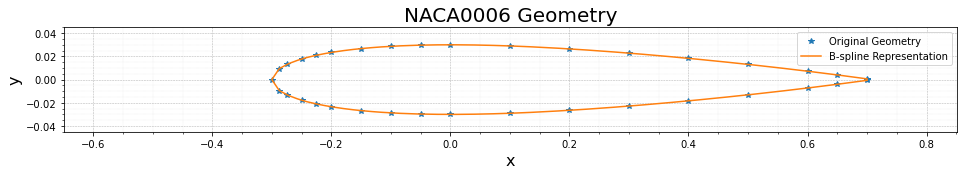

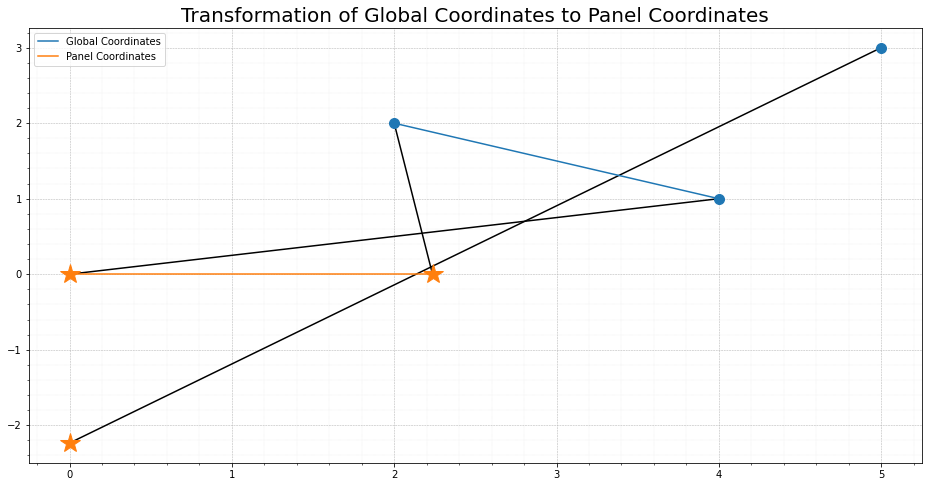

In [4]:
N = 128
airfoilName = "NACA0006"

PlotAirfoil( N, airfoilName )

fig, ax = plt.subplots(figsize=(16, 8))
plt.title( "Transformation of Global Coordinates to Panel Coordinates", fontsize=20 )
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
x1 = [5, 4, 2]; y1 = [3, 1, 2]
x2 = [0, 0, 5**.5]; y2 = [-5**.5, 0, 0]
i = 0
for x in x1:
    plt.plot( [x1[i], x2[i]], [y1[i], y2[i]], 'k' )
    i = i + 1
plt.plot( x1, y1, '.', markersize=20 )
plt.plot( x2, y2, '*', markersize=20 )
plt.plot( [4, 2], [1, 2], 'tab:blue', label="Global Coordinates")
plt.plot( [0,5**.5], [0,0], 'tab:orange', label="Panel Coordinates")
plt.legend()


# Numerical Code Based on the Neumann Boundary Condition

Since we are interested on the lifting case of the potential flow, we will ignore any numerical method that cannot predict the lift, such as those based on source elements. We therefore start with the Constant-Strength Doublet Method, and continue from here to other methods, including those based on boundary integral methods of the class. A list of the methods that will be utilized on this problem are:
1. Constant-Strength Doublet Element Method
2. Constant-Strength Source Element & Constant-Strength Doublet Element Method
3. Constant-Strength Potential Panel Method
4. Linear-Strength Doublet Element Method
5. Linear-Strength Source Element & Linear-Strength Doublet Element Method
6. Linear-Strength Potential Panel Method
7. Linear-Strength Vortex Element Method
8. Boundary Integral Method using Trapezoidal Rule
9. Boundary Integral Method using Midpoint Rule
10. Boundary Integral Method using Gauss Quadrature
11. Boundary Integral Method using Clenshaw-Curtis Quadrature


## 1. Constant-Strength Doublet Element Method

In [5]:
def DUB2DC( x, y, x1, y1, x2, y2 ): ## given global coordinates
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity by the doublet (in panel coordinates)
    up = ( yp / ( (xp-xp1)**2 + yp**2 ) - yp / ( (xp-xp2)**2+yp**2 ) )/2/pi
    vp = -( (xp-xp1) / ( (xp-xp1)**2 + yp**2 ) - (xp-xp2) / ( (xp-xp2)**2+yp**2 ) )/2/pi
    
    ## transform from panel coordinates to global coordinates (velocity)
    c = cos(alpha); s = sin(alpha)
    u = c*up - s*vp; v = s*up + c*vp
    return u, v

def NeumannConstantStrengthDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
#     tx, ty = computeTangent( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( np.diff(y), np.diff(x) )
    txc = np.cos( panelAlpha ); tyc = np.sin( panelAlpha )
    nxc = np.sin( panelAlpha ); nyc = -np.cos( panelAlpha )
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+2)x(N+2) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = -U0 * ( cos( AOA * pi / 180 ) * nxc[i] + sin( AOA * pi / 180 ) * nyc[i] )
        for j in range( N ):
            ## first panel point & second panel point
            u, v = DUB2DC( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = (u*nxc[i] + v*nyc[i])
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            u, v = DUB2DC( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + (u*nxc[i] + v*nyc[i])
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, b, x, y, xc, yc, txc, tyc


print("ComputeAlpha")
print( ComputeAlpha( 1, 0, 0, 1) )
print( pi/4 +pi/2 )
print("")
print( ComputeAlpha( 1, 0, 0, -1) )
print( -(pi/4 +pi/2) )
print("\n")

print("GlobalToPanelCoords")
print( GlobalToPanelCoords( 5, 3, 4, 1, 2, 2 ) )
print( "(", 0, -5**.5, 0, 0, 5**.5, 0, ")")
print("")
print( GlobalToPanelCoords( 3, -1, 4, 1, 2, 2 ) )
print( "(", 0, 5**.5, 0, 0, 5**.5, 0, ")")
print("\n")



print("DUB2DC")
u, v = DUB2DC(0, 0, 1, 0, -1, 0)
print(u, v)  
print( 0.0, 1/pi )
print("")
u, v = DUB2DC(0, 0, -1, 0, 1, 0)
print(u, v)  
print( 0.0, -1/pi )
print("")
u, v = DUB2DC(0, 0, 1/np.sqrt(2), -1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2))
print(u, v)  
print( 1/pi/2**.5, 1/pi/2**.5 )





ComputeAlpha
2.356194490192345
2.356194490192345

-2.356194490192345
-2.356194490192345


GlobalToPanelCoords
(3.3306690738754696e-16, -2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 -2.23606797749979 0 0 2.23606797749979 0 )

(-3.3306690738754696e-16, 2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 2.23606797749979 0 0 2.23606797749979 0 )


DUB2DC
3.8981718325193755e-17 0.3183098861837907
0.0 0.3183098861837907

0.0 -0.3183098861837907
0.0 -0.3183098861837907

0.2250790790392766 0.22507907903927654
0.22507907903927651 0.22507907903927651


/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
1.8056953108098373


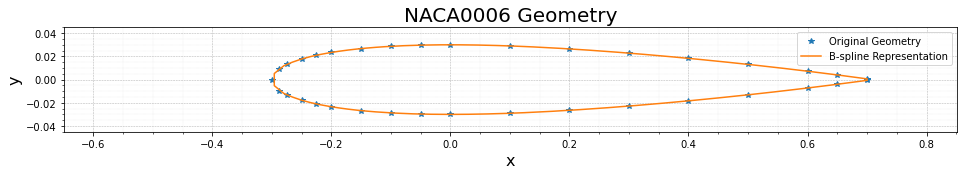

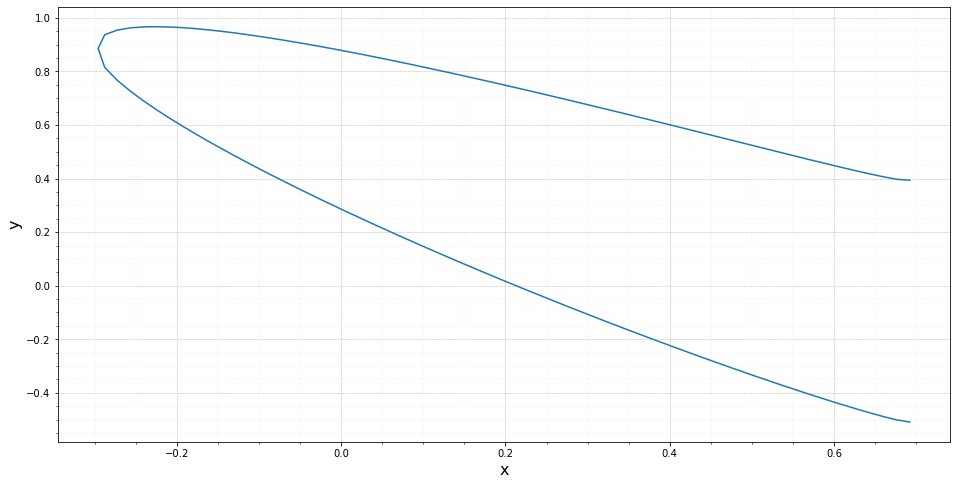

In [6]:
N = 128 + 1 
U0 = 1
AOA = 15
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
PlotAirfoil( N, airfoilName )
Y = Y

## generate system of eqns
A, b, x, y, xc, yc, txc, tyc = NeumannConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
nu = np.linalg.solve( A, b )
print( nu[-1]*2 )
nu = nu[:-1]

fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)

plt.plot( xc, nu )



## 2. Constant-Strength Source Element & Constant-Strength Doublet Element Method

## 3. Constant-Potential Panel Method


Here we take $\phi$ to be constant on each of the N panels,
<center> $ \phi = \phi_j $ </center>

The equation takes the form:
<center> $ \phi_i = U_{\infty}[x_i\text{cos}(\alpha) + y_i\text{sin}(\alpha)]-\sum \phi_j \int_{\text{panel j}} \text{$\textbf{n}$} \cdot \nabla \phi_s dS - \Gamma \int_{S_W}  $ </center>
<center> for i = 1, 2, 3, ..., N </center>

where $\phi_s$ is simply the potential due to a source term of unit strength in 2 dimensions. (Actually in more simplle terms it's simply the Green function G)


In [7]:
def PHI2DC( x, y, x1, y1, x2, y2 ): ## given global coordinates
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced potential by the panel (in panel coordinates)
    phi = ( -atan2(xp-xp2, yp) + atan2(xp-xp1, yp) )/2/pi
    
#     phi = atan2( (y-y1)*(x-x2)-(x-x1)*(y-y2), (x-x1)*(x-x2)+(y-y1)*(y-y2) )/2/pi
#     phi = atan2( (y-y2)*(x-x1)-(x-x2)*(y-y1), (x-x2)*(x-x1)+(y-y2)*(y-y1) )/2/pi
    
    return phi

def NeumannConstantPotentialPanelMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( np.diff(y), np.diff(x) )
    txc = np.cos( panelAlpha ); tyc = np.sin( panelAlpha )
    nxc = np.sin( panelAlpha ); nyc = -np.cos( panelAlpha )
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )

    # generate a (N+1)x(N+1) system of equations
    # where the last row is to apply the kutta-condition
#     A = -np.eye( N+1 )
    A = np.zeros( (N+1,N+1))
    b = np.zeros( N+1 )
    t = np.linspace(0, 1, N)

    for i in range(N):
        b[i] = -U0 * ( cos( AOA * pi / 180 ) * xc[i] + sin( AOA * pi / 180 ) * yc[i] )
        for j in range(N):
#             if i == j:
#                 phi = 1/2
#             else:
#                 phi = PHI2DC( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
#             A[i, j] = A[i, j] + phi
            
            phi = PHI2DC( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = A[i, j] + phi
        
    ## create wake
    for i in range(N):
        phi =  PHI2DC( xc[i], yc[i], xw[0], yw[0], xw[-1], yw[-1] )
        A[i, -1] = -phi
    
    ## define kutta condition
    A[-1, 0] = 1; A[-1, -2] = -1; A[-1,-1] = -1
    
    return A, b, x, y, xc, yc



print("PHI2DC")
phi = PHI2DC(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( 0.0, 1/pi )
print("")
u, v = DUB2DC(0, 0, -1, 0, 1, 0)
print(u, v)  
print( 0.0, -1/pi )
print("")
u, v = DUB2DC(0, 0, 1/np.sqrt(2), -1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2))
print(u, v)  
print( 1/pi/2**.5, 1/pi/2**.5 )
            


PHI2DC
0.49999999999968164
0.0 0.3183098861837907

0.0 -0.3183098861837907
0.0 -0.3183098861837907

0.2250790790392766 0.22507907903927654
0.22507907903927651 0.22507907903927651


/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[[ 5.000e-01  1.292e-04  1.024e-04 ...  2.969e-02  4.078e-01 -6.532e-02]
 [ 1.292e-04  5.000e-01  1.277e-04 ...  3.345e-01  5.518e-02 -5.685e-02]
 [ 1.030e-04  1.277e-04  5.000e-01 ...  7.166e-02  1.757e-02 -5.507e-02]
 ...
 [ 5.518e-02  3.345e-01  5.059e-02 ...  5.000e-01  1.292e-04 -2.648e-02]
 [ 4.078e-01  2.969e-02  6.319e-03 ...  1.292e-04  5.000e-01 -1.801e-02]
 [ 1.000e+00  0.000e+00  0.000e+00 ...  0.000e+00 -1.000e+00 -1.000e+00]]
-1.8081479695546003


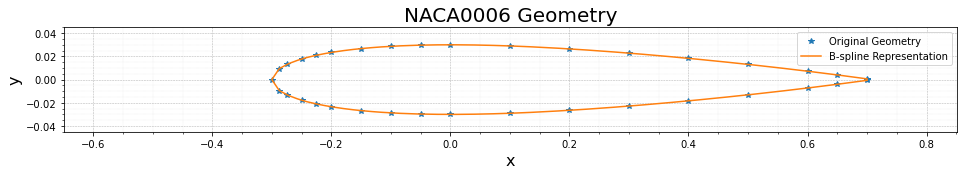

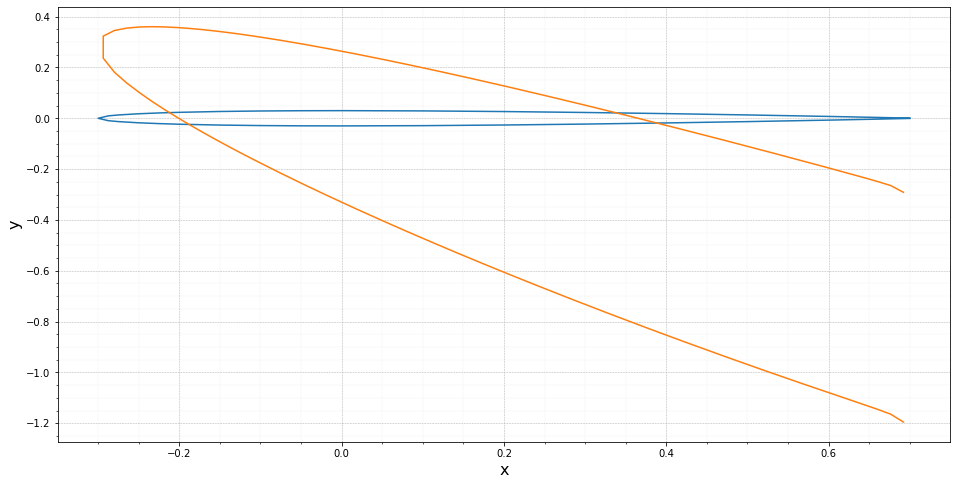

In [9]:
N = 128
U0 = 1
AOA = 15
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
PlotAirfoil( N, airfoilName )

## create geometry
M = 1024
c = 1
e = 0.5
a = c * ( 1 + e ) / 4

# t = np.linspace( 0, 1, M )
# X0 = - e * c / 4
# X = a * np.cos( 2 * pi * t ) + X0
# Y = a * np.sin( 2 * pi * t )
# Z = X + 1j*Y
# Z = Z + c**2/Z/16
# X = np.real(Z)
# Y = np.imag(Z)
# fig, ax = plt.subplots(figsize=(16, 8))
# plt.plot( X, Y )
# C = ( np.max(X)-np.min(X))
# X = X 
A, b, x, y, xc, yc = NeumannConstantPotentialPanelMethod( X, Y, N, U0, AOA )
print( A )

fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = np.linalg.solve( A, b )
# nu, res, rank, s  = np.linalg.lstsq( A, b )
print( nu[-1]*2 )
nu = nu[:-1]
plt.plot( X, Y )
plt.plot( xc, nu )


## 4. Linear-Strength Vortex Element Method

The induced velocity by a linear-strength vortex are:

<center> $ u_p = \frac{\gamma_0}{2\pi}[tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}] + \frac{\gamma_1}{4\pi}[y ln\frac{(x-x_1)^2+y^2}{(x-x_2)^2+y^2} + 2x(tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1})] $ </center>
<center> $ v_p = -\frac{\gamma_0}{4\pi}ln\frac{(x-x_1)^2+y^2}{(x-x_2)^2+y^2} - \frac{\gamma_1}{2\pi} [ \frac{x}{2}ln\frac{(x-x_1)^2+y^2}{(x-x_2)^2+y^2} + (x_1-x_2) + y(tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1})] $ </center>



In [242]:
def VOR2DL( x, y, x1, y1, x2, y2 ): ## given global coordinates
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity by the vortex element (in panel coordinates)
#     up1 = (atan2(yp,xp-xp2) - atan2(yp,xp-xp1))/2/pi
#     up2 = (yp* log( ((xp-xp1)**2+yp**2) / ((xp-xp2)**2+yp**2)) + 2*xp*(atan2(yp,xp-xp2)-atan2(yp,xp-xp1)) )/4/pi
#     vp1 = -log( ((xp-xp1)**2+yp**2) / ((xp-xp2)**2+yp**2) )/4/pi
#     vp2 = -( xp/2*log( ((xp-xp1)**2+yp**2)/((xp-xp2)**2+yp**2) ) + (xp1-xp2) + yp*(atan2(yp,xp-xp2)-atan2(yp,xp-xp1) ) )/2/pi
    up1 = yp/4/pi / (xp2-xp1) * log( ((xp-xp1)**2+yp**2)/((xp-xp2)**2+yp**2) )\
    + (xp2-xp)/2/pi/(xp2-xp1) * ( atan2(yp,xp-xp2)-atan2(yp,xp-xp1) )
    up2 = -yp/4/pi / (xp2-xp1) * log( ((xp-xp1)**2+yp**2)/((xp-xp2)**2+yp**2) )\
    + (xp-xp1)/2/pi/(xp2-xp1) * ( atan2(yp,xp-xp2)-atan2(yp,xp-xp1) )
    vp1 = -(xp2-xp)/4/pi/(xp2-xp1) * log( ((xp-xp1)**2+yp**2)/((xp-xp2)**2+yp**2) )\
    - 1/2/pi / (xp2-xp1) * ( (xp2-xp1) +  yp*(atan2(yp,xp-xp2)-atan2(yp,xp-xp1)) )
    vp2 = -(xp-xp1)/4/pi/(xp2-xp1) * log( ((xp-xp1)**2+yp**2)/((xp-xp2)**2+yp**2) )\
    + 1/2/pi / (xp2-xp1) * ( (xp2-xp1) +  yp*(atan2(yp,xp-xp2)-atan2(yp,xp-xp1)) )
    
    ## transform from panel coordinates to global coordinates (velocity)
    c = cos(alpha); s = sin(alpha)
    u1 = c*up1 - s*vp1; v1 = s*up1 + c*vp1
    u2 = c*up2 - s*vp2; v2 = s*up2 + c*vp2
    
    return u1, v1, u2, v2
    

def NeumannLinearStrengthVortexMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    binormal = computeBinormal( N+1, tck )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( np.diff(y), np.diff(x) )
    txc = np.cos( panelAlpha ); tyc = np.sin( panelAlpha )
    nxc = np.sin( panelAlpha ); nyc = -np.cos( panelAlpha )
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+1)x(N+1) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N+1, N+1) )
    b = np.zeros( N+1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = -U0 * ( cos( AOA * pi / 180 ) * nxc[i] + sin( AOA * pi / 180 ) * nyc[i] )
        ## go through each panel
        for j in range( N ):
            
            ## velocity at collocation point i due to panel j
            u1, v1, u2, v2 = VOR2DL( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            ### due to trailing edge
            A[i, j] = A[i, j] + (u1*nxc[i] + v1*nyc[i])
            ### due to leading edge
            A[i, j+1] = A[i, j+1] + (u2*nxc[i] + v2*nyc[i])

    ## include Kutta Condition
    A[-1, 0] = 1; A[-1, -1] = 1;   

    return A, b, x, y, xc, yc, txc, tyc


print("ComputeAlpha")
print( ComputeAlpha( 1, 0, 0, 1) )
print( pi/4 +pi/2 )
print("")
print( ComputeAlpha( 1, 0, 0, -1) )
print( -(pi/4 +pi/2) )
print("\n")

print("GlobalToPanelCoords")
print( GlobalToPanelCoords( 5, 3, 4, 1, 2, 2 ) )
print( "(", 0, -5**.5, 0, 0, 5**.5, 0, ")")
print("")
print( GlobalToPanelCoords( 3, -1, 4, 1, 2, 2 ) )
print( "(", 0, 5**.5, 0, 0, 5**.5, 0, ")")
print("\n")

print("DUB2DC")
u, v = DUB2DC(0, 0, 1, 0, -1, 0)
print(u, v)  
print( 0.0, 1/pi )
print("")
u, v = DUB2DC(0, 0, -1, 0, 1, 0)
print(u, v)  
print( 0.0, -1/pi )
print("")
u, v = DUB2DC(0, 0, 1/np.sqrt(2), -1/np.sqrt(2), -1/np.sqrt(2), 1/np.sqrt(2))
print(u, v)  
print( 1/pi/2**.5, 1/pi/2**.5 )






ComputeAlpha
2.356194490192345
2.356194490192345

-2.356194490192345
-2.356194490192345


GlobalToPanelCoords
(3.3306690738754696e-16, -2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 -2.23606797749979 0 0 2.23606797749979 0 )

(-3.3306690738754696e-16, 2.23606797749979, 0, 0, 2.23606797749979, 3.3306690738754696e-16, 2.677945044588987)
( 0 2.23606797749979 0 0 2.23606797749979 0 )


DUB2DC
3.8981718325193755e-17 0.3183098861837907
0.0 0.3183098861837907

0.0 -0.3183098861837907
0.0 -0.3183098861837907

0.2250790790392766 0.22507907903927654
0.22507907903927651 0.22507907903927651


/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[[ 0.159 -0.262 -0.116 ... -0.116 -0.269  0.232]
 [ 0.072  0.262 -0.262 ... -0.289  0.337  0.094]
 [ 0.037  0.116  0.262 ...  0.319  0.148  0.049]
 ...
 [-0.094 -0.337  0.289 ...  0.262 -0.262 -0.072]
 [-0.232  0.269  0.116 ...  0.116  0.262 -0.159]
 [ 1.     0.     0.    ...  0.     0.     1.   ]]
[-0.069 -0.066 -0.064 -0.062 -0.059 -0.057 -0.055 -0.053 -0.051 -0.049
 -0.047 -0.045 -0.042 -0.04  -0.037 -0.034 -0.03  -0.027 -0.023 -0.018
 -0.013 -0.007 -0.001  0.006  0.015  0.025  0.036  0.051  0.07   0.095
  0.139  0.23   1.     0.23   0.139  0.095  0.07   0.051  0.036  0.025
  0.015  0.006 -0.001 -0.007 -0.013 -0.018 -0.023 -0.027 -0.03  -0.034
 -0.037 -0.04  -0.042 -0.045 -0.047 -0.049 -0.051 -0.053 -0.055 -0.057
 -0.059 -0.062 -0.064 -0.066 -0.069  0.   ]
3.7842529097460402


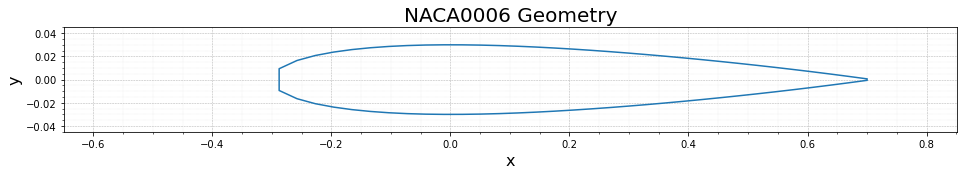

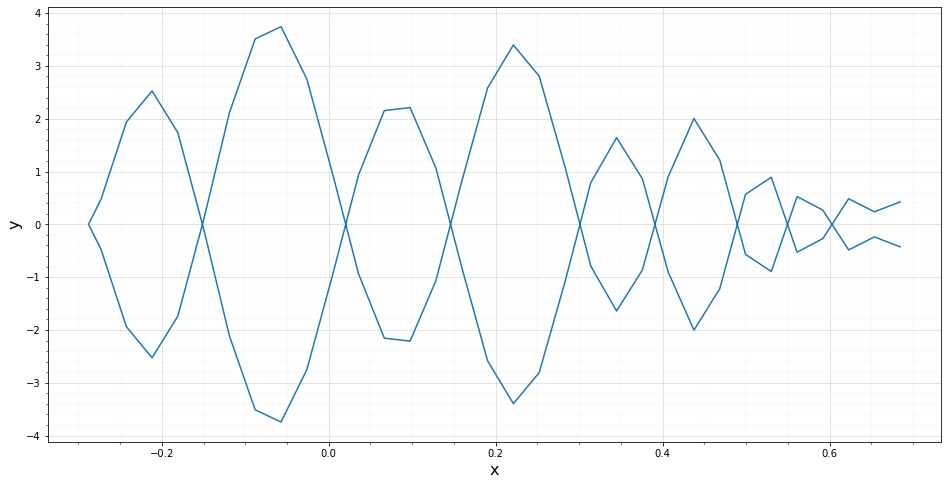

In [243]:
N = 65
U0 = 1
AOA = 0
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
PlotAirfoil( N, airfoilName )

A, b, x, y, xc, yc, txc, tyc = NeumannLinearStrengthVortexMethod( X, Y, N, U0, AOA )
print( A )
print( b )
fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = np.linalg.solve( A, b )
print( -nu[-1]*2 )
# nu = nu[:-1]
# print(nu)
# plt.plot( x, y )

Qt = U0 + np.vstack([nu[1:], nu[:-1]]).mean(axis=0)/4
cp = 1 - (Qt/U0)**2
plt.plot( xc, np.vstack([nu[1:], nu[:-1]]).mean(axis=0)/4 )





## 8. Boundary Integral Method using Trapezoidal Rule

In [1097]:
def createPeriodicSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0, per=1)
    return tck

def createSplines( X, Y ):
    tck, u = interpolate.splprep([X, Y], s=0 )
    return tck

def computeNodeLocations( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    x, y = interpolate.splev(t, tck)
    return x, y

def computeNormParameterizationDerivative( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    dx_dt, dy_dt = interpolate.splev(t, tck, der=1)
    ds_dt = np.sqrt( dx_dt**2 + dy_dt**2 )
    return ds_dt

## this function I think is unnecessary but not sure
def computeRadial( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    rx, ry = interpolate.splev(t, tck)
    norm = np.sqrt( rx**2 + ry**2 )
    return rx/norm, ry/norm

def computeTangent( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    tx, ty = interpolate.splev(t, tck, der=1)
    norm = np.sqrt( tx**2 + ty**2 )
    return tx/norm, ty/norm

def computeNormal( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    nx, ny = interpolate.splev(t, tck, der=2)
    norm = -np.sqrt( nx**2 + ny**2 )
    return nx/norm, ny/norm

def computeBinormal( N, tck ):
    tx, ty = computeTangent( N, tck )
    nx, ny = computeNormal( N, tck )
    tangentVector = np.vstack( (tx, ty) )
    normalVector = np.vstack( (nx, ny) )
    binormal = np.cross( np.transpose(tangentVector), np.transpose(normalVector) )
    return -binormal

def computeCurvature( N, tck ):
    t = np.linspace( 0, 1, N )
    dt = 1 / (N-1)/2 ## actualy dt over 2
    t[0] = dt; t[-1] = 1-dt
    d1x, d1y = interpolate.splev(t, tck, der=1)
    d2x, d2y = interpolate.splev(t, tck, der=2)
    curvature = (d2x*d1y - d2y*d1x) / (d1x**2+d1y**2)**(3/2)
    return curvature

def computeChordLength( X ):
    return np.max(X) - np.min(X)

def computeAirfoilPseudoThickness( Y ):
    return np.max(Y) - np.min(Y)

def createWakeGeometry( X, Y, AOA ):
    chordLength = computeChordLength( X )
    wakeLength = 1000 * chordLength
    x0 = .5 * ( X[0] + X[-1] )
    y0 = .5 * ( Y[0] + Y[-1] )
    xf = x0 + wakeLength * np.cos( AOA * pi/180 )
    yf = y0 + wakeLength * np.sin( AOA * pi/180 )
    Xw = np.asarray( [x0, xf] )
    Yw = np.asarray( [y0, yf] )
    tck, u = interpolate.splprep([Xw, Yw], k=1, s=0, quiet=True )
    return tck

def computeWakeNormal( Nw, AOA ):
    nxw = -np.sin( AOA * pi/180 ) * np.ones( Nw )
    nyw = np.cos( AOA * pi/180 ) * np.ones( Nw )
    return nxw, nyw

def ComputeAlpha( x1, y1, x2, y2 ):
    return atan2( -(y1-y2), -(x1-x2) )

def GlobalToPanelCoords( x, y, x1, y1, x2, y2 ):
    alpha = ComputeAlpha( x1, y1, x2, y2 )
    
    ## first displace all points such that the coordinate system origin is on (x1, y1)
    xp = cos(alpha) * ( x - x1 ) + sin(alpha) * ( y - y1 )
    yp = -sin(alpha) * ( x - x1 ) + cos(alpha) * ( y - y1 )
    xp1 = 0 
    yp1 = 0 
    xp2 = cos(alpha) * ( x2 - x1 ) + sin(alpha) * ( y2 - y1 )
    yp2 = -sin(alpha) * ( x2 - x1 ) + cos(alpha) * ( y2 - y1 )
    
    return xp, yp, xp1, yp1, xp2, yp2, alpha
    

In [122]:
from math import sqrt, log

def computeGreen2D( x, y, xj, yj ):
    rj = sqrt( (x - xj)**2 + (y - yj)**2 )
    if rj != 0: 
        G = log( rj )/2/pi
        return G
    else: 
        return -100

def computeGreenNormal2D( x, y, xj, yj , normalx, normaly, curvature ):
    if sqrt( (x-xj)**2 + (y-yj)**2 ) < 1e-6:
        return curvature/2
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2 
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn

def NeumannTrapezoidalRule( X, Y, N, U0, AOA ):
    ## check if the geometry has sharp trailing edge
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    tx, ty = computeTangent( N+1, tck )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )
    curvature = computeCurvature( N+1, tck )
    
    ## correct normal direction
#     nx = binormal * nx
#     ny = binormal * ny
    
    ## generate system of equations
    A = -np.eye( N + 1 )
    b = np.zeros( N + 1 )
    dt = 1/ N
    

    for i in range( N+1 ):
        b[i] = -U0 * ( x[i] * np.cos( AOA * pi / 180 ) +  y[i] * np.sin( AOA * pi / 180 ) )
        for j in range( N ):
            if j == 0:
                gij = -computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j], curvature[j] ) * ds_dt[j] * dt 
                A[i, j] = A[i, j] + gij
            elif j == N-1:
                gij = -computeGreenNormal2D( x[i], y[i], x[N], y[N], nx[N], ny[N], curvature[N] ) * ds_dt[N] * dt 
                A[i, N] = A[i, N] + gij
            else:
                ## first part
                gij = -computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j], curvature[j] ) * ds_dt[j] * dt / 2
                A[i, j] = A[i, j] + gij

                ## second part
                gij = -computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1], curvature[j+1] ) * ds_dt[j+1] * dt / 2
                A[i, j+1] = A[i, j+1] + gij
                
#             ## first part
#             if i != j:
#                 if j == 0:
#                     gij = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j], curvature[j] ) * ds_dt[j] * dt 
#                     A[i, i] = A[i, i] - gij
#                     A[i, j] = A[i, j] + gij
#                 else:
#                     gij = computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j], curvature[j] ) * ds_dt[j] * dt /2
#                     A[i, i] = A[i, i] - gij
#                     A[i, j] = A[i, j] + gij
#             if i != j+1:
#                 gij = computeGreenNormal2D( x[i], y[i], x[j+1], y[j+1], nx[j+1], ny[j+1], curvature[j+1] ) * ds_dt[j+1] * dt / 2
#                 A[i, i] = A[i, i] - gij
#                 A[i, j+1] = A[i, j+1] + gij
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
        
    ## create wake
    for i in range( N+1 ):
        phi =  PHI2DC( x[i], y[i], xw[0], yw[0], xw[-1], yw[-1] )
        A[i, 0] = A[i, 0] - phi
        A[i, -1] = A[i, -1] + phi


                
    return A, b, x, y 
 
def plotGreenfunction( X, Y, N ):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    tx, ty = computeTangent( N+1, tck )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )
    curvature = computeCurvature( N+1, tck )
    
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
    plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
    plt.minorticks_on()
    plt.xlabel(xlabel='x', fontsize=16)
    plt.ylabel(ylabel='y', fontsize=16)
    t = np.linspace(0, 1, N+1 )
    for i in range( N+1 ):
#         G = []
        Gn = []
        for j in range( N+1 ):
#             G.append( computeGreen2D( x[i], y[i], x[j], y[j] ) )
            Gn.append( computeGreenNormal2D( x[i], y[i], x[j], y[j], nx[j], ny[j], curvature[j] ) )
#         G = np.asarray( G )
        Gn = np.asarray( Gn )
#         plt.plot( t, G, '*' )
        plt.plot( t, Gn, '--*' )
    



/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[[-7.180e-01 -5.051e-04 -7.702e-04 ... -1.511e-02 -1.999e-02 -4.781e-01]
 [ 1.594e-01 -9.979e-01 -8.682e-04 ... -3.813e-02 -3.666e-02 -2.677e-01]
 [ 1.426e-01 -1.671e-04 -9.958e-01 ... -4.526e-02 -3.080e-02 -2.079e-01]
 ...
 [-1.524e-01 -3.080e-02 -4.526e-02 ... -9.958e-01 -1.671e-04  8.708e-02]
 [-2.121e-01 -3.666e-02 -3.813e-02 ... -8.682e-04 -9.979e-01  1.039e-01]
 [-4.225e-01 -1.999e-02 -1.511e-02 ... -7.702e-04 -5.051e-04 -7.736e-01]]
0.5680609406842021 0.5542876318981653


/Users/daniellam/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


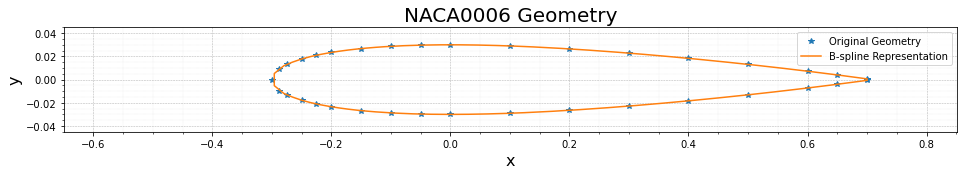

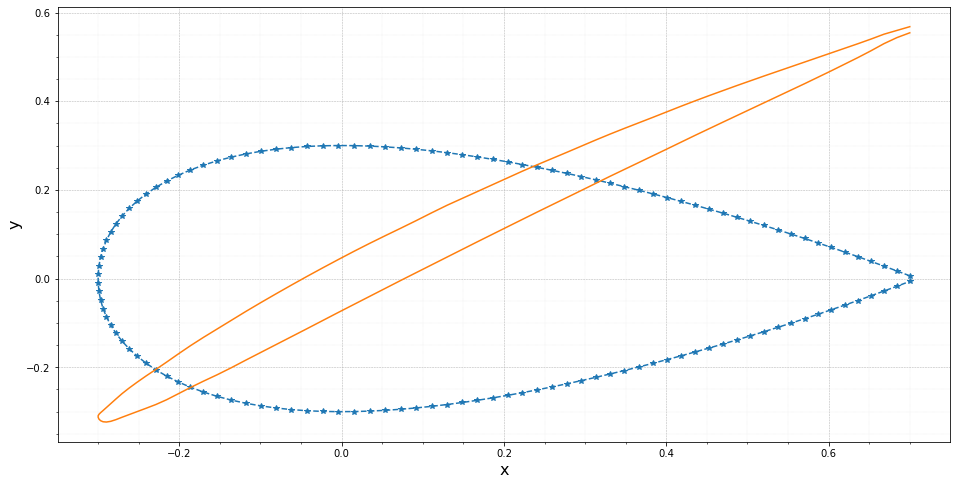

In [123]:
N = 129
U0 = 1
AOA = 10
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
Y = 10*Y
PlotAirfoil( N, airfoilName )

A, b, x, y = NeumannTrapezoidalRule( X, Y, N, U0, AOA )
print( A )


fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = np.linalg.solve( A, b )
nu = np.linalg.lstsq( A, b )
# print( -nu[-1]*2 )
# nu = nu[:-1]
# print(nu)
plt.plot( x, y, '--*' )
plt.plot( x, nu[0] )
print( nu[0][0], nu[0][-1] )



## Numerical Code Based on the Dirichlet Boundary Condition

We now focus on the Dirichlet formulation of the lifting problem. Similar to above, we start from the simplest method and work up to higher order methods. A list of the methods that will be utilized on this problem are:
1. Constant-Strength Doublet Element Method
2. Constant-Strength Source Element & Constant-Strength Doublet Element Method
3. Constant-Strength Potential Panel Method
4. Constant-Strength Vortex Element Method
5. Linear-Strength Doublet Element Method
6. Linear-Strength Source Element & Linear-Strength Doublet Element Method
7. Linear-Strength Potential Panel Method
8. Linear-Strength Vortex Element Method
9. Boundary Integral Method using Trapezoidal Rule
10. Boundary Integral Method using Midpoint Rule
11. Boundary Integral Method using Gauss Quadrature
12. Boundary Integral Method using Clenshaw-Curtis Quadrature

## 1. Constant-Strength Doublet Element Method

The velocity potential  at a point P due to a constant-strength doublet element is:
<center> $ \phi = -\frac{\mu}{2\pi} [tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}] $ </center>

In [128]:
def PHICD( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the doublet element (in panel coordinates)
    phi = -( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) )/2/pi
    return phi 

print("PHICD")
print("Taking the num limit to 0+ of phi")
phi = PHICD(0, 0+1e-12, 1, 0, -1, 0)
print( phi )  
print( 1/2 )
print("")
print("Taking the num limit to 0- of phi")
phi = PHICD(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( -1/2 )
print("")


def DirichletConstantStrengthDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    dx = np.diff(x)
    dy = np.diff(y)
    panelLength = np.sqrt( dx**2 + dy**2 )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( dy, dx )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## displace collocation point inward by 0.05 of the panel length
    xc = xc - 0.05*panelLength*nxc; yc = yc - 0.05*panelLength*nyc;
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+2)x(N+2) system of equations
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        b[i] = -U0 * ( xc[i] * np.cos( AOA * pi / 180 ) + yc[i] * np.sin( AOA * pi / 180 ) )
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICD( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = phi
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            phi = PHICD( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + phi
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, b, x, y, xc, yc





PHICD
Taking the num limit to 0+ of phi
0.49999999999968164
0.5

Taking the num limit to 0- of phi
-0.49999999999968164
-0.5



/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[[-0.468 -0.011 -0.002 ... -0.021 -0.437 -0.049]
 [-0.011 -0.468 -0.011 ... -0.359 -0.047 -0.051]
 [-0.002 -0.011 -0.468 ... -0.066 -0.016 -0.052]
 ...
 [-0.047 -0.359 -0.044 ... -0.468 -0.011 -0.032]
 [-0.437 -0.021 -0.004 ... -0.011 -0.468 -0.034]
 [ 1.     0.     0.    ...  0.    -1.     1.   ]]
[-0.669 -0.654 -0.639 -0.624 -0.609 -0.594 -0.579 -0.564 -0.55  -0.535
 -0.52  -0.505 -0.49  -0.475 -0.46  -0.445 -0.43  -0.415 -0.4   -0.385
 -0.37  -0.355 -0.34  -0.325 -0.31  -0.296 -0.281 -0.266 -0.251 -0.235
 -0.22  -0.205 -0.19  -0.175 -0.16  -0.145 -0.13  -0.115 -0.1   -0.085
 -0.07  -0.055 -0.04  -0.024 -0.009  0.006  0.021  0.036  0.052  0.067
  0.082  0.097  0.113  0.128  0.143  0.159  0.174  0.19   0.205  0.221
  0.236  0.252  0.267  0.282  0.284  0.273  0.259  0.245  0.23   0.216
  0.201  0.186  0.172  0.157  0.142  0.127  0.112  0.

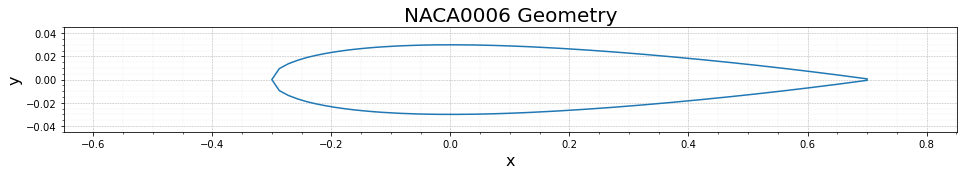

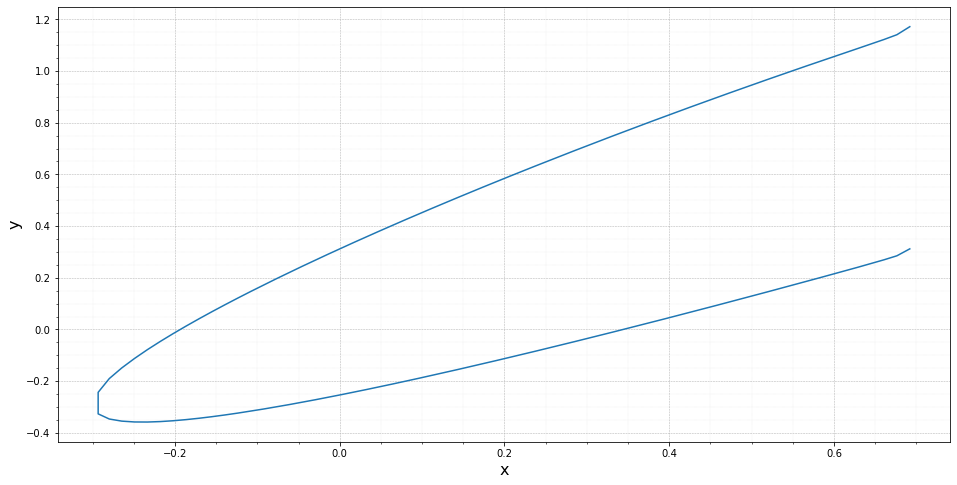

In [148]:
N = 128
U0 = 1
AOA = 15
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
PlotAirfoil( N, airfoilName )

A, b, x, y, xc, yc = DirichletConstantStrengthDoubletMethod( X, Y, N, U0, AOA )
print( A )
print( b )
fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = np.linalg.solve( A, b )
print( -nu[-1]*2 )
nu = nu[:-1]
plt.plot( xc, nu )




# 2. Constant Source / Constant Doublet Method

The velocity potential at a point P due to a constant-strength source element is:
<center> $ \phi = \frac{ \sigma }{ 4 \pi } \{(x-x_1)ln[(x-x_1)^2+y^2] - (x-x_2)ln[(x-x_2)^2+y^2] + 2z(tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}) \} $ </center>

The velocity potential  at a point P due to a constant-strength doublet element is:
<center> $ \phi = -\frac{\mu}{2\pi} [tan^{-1}\frac{y}{x-x_2} - tan^{-1}\frac{y}{x-x_1}] $ </center>




In [142]:
def PHICS( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the source element (in panel coordinates)
    phi = ( ( xp-xp1 )*log( ( xp-xp1 )**2 + yp**2 )\
          - ( xp-xp2 )*log( ( xp-xp2 )**2 + yp**2 )\
          + 2*yp*( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) ) )/4/pi
    return phi

def PHICD( x, y, x1, y1, x2, y2 ):
    ## transform from global coordinates to panel coordinates (coordinates)
    xp, yp, xp1, yp1, xp2, yp2, alpha = GlobalToPanelCoords( x, y, x1, y1, x2, y2 )
    
    ## compute induced velocity potential by the doublet element (in panel coordinates)
    phi = -( atan2( yp, (xp-xp2 ) ) - atan2( yp, (xp-xp1 ) ) )/2/pi
    return phi 

def DirichletConstantStrengthSourceDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    dx = np.diff(x)
    dy = np.diff(y)
    panelLength = np.sqrt( dx**2 + dy**2 )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( dy, dx )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## displace collocation point inward by 0.05 of the panel length
    xc = xc - 0.05*panelLength*nxc; yc = yc - 0.05*panelLength*nyc;
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+1)x(N+1) sys of eqns related to the source elements
    B = np.zeros( (N+1, N+1) )
    sigma = np.zeros( N+1 )
    
    for i in range( N ):
        sigma[i] = -U0 * ( np.cos( AOA * pi / 180 )*nxc[i] + np.sin( AOA * pi / 180 )*nyc[i] )
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICS( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            B[i, j] = phi
    
    
    # generate a (N+2)x(N+2) system of equations related to the doublet elements
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICD( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = phi
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            phi = PHICD( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + phi
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, B, sigma, x, y, xc, yc


print("PHICS")
ds = 1e-8
phi0 = PHICS(0, 0, 1, 0, -1, 0)
phi1 = PHICS(0, 0+ds, 1, 0, -1, 0)
phi2 = PHICS(0, 0-ds, 1, 0, -1, 0)
print("Obtaining the num limit to 0+ of u")
print( (phi1-phi0)/ds )
print( .5 )
print("Obtaining the num limit to 0+ of u")
print( (phi0-phi2)/ds )
print( -.5 )
print("\n")

print("PHICD")
print("Taking the num limit to 0+ of phi")
phi = PHICD(0, 0+1e-12, 1, 0, -1, 0)
print( phi )  
print( 1/2 )
print("")
print("Taking the num limit to 0- of phi")
phi = PHICD(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( -1/2 )
print("")







PHICS
Obtaining the num limit to 0+ of u
0.4999999845704332
0.5
Obtaining the num limit to 0+ of u
-0.49999999681690116
-0.5


PHICD
Taking the num limit to 0+ of phi
0.49999999999968164
0.5

Taking the num limit to 0- of phi
-0.49999999999968164
-0.5



/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
/Users/daniellam/Google Drive/python/Boundary Integral Method/NACA0006.dat
[[-0.468 -0.011 -0.002 ... -0.021 -0.437 -0.05 ]
 [-0.011 -0.468 -0.011 ... -0.359 -0.047 -0.051]
 [-0.002 -0.011 -0.468 ... -0.066 -0.016 -0.052]
 ...
 [-0.047 -0.359 -0.044 ... -0.468 -0.011 -0.032]
 [-0.437 -0.021 -0.004 ... -0.011 -0.468 -0.034]
 [ 1.     0.     0.    ...  0.    -1.     1.   ]]
[[-0.012 -0.008 -0.006 ... -0.008 -0.011  0.   ]
 [-0.008 -0.012 -0.008 ... -0.01  -0.008  0.   ]
 [-0.006 -0.008 -0.012 ... -0.008 -0.006  0.   ]
 ...
 [-0.008 -0.01  -0.008 ... -0.012 -0.008  0.   ]
 [-0.011 -0.008 -0.006 ... -0.008 -0.012  0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]
[-0.325 -0.324 -0.323 -0.322 -0.321 -0.319 -0.318 -0.317 -0.316 -0.315
 -0.314 -0.313 -0.312 -0.311 -0.31  -0.309 -0.308 -0.307 -0.306 -0.305
 -0.304 -0.303 -0.302 -0.301 -0.3   -0.298 -0.297 -0.296 -0.295 -0.293
 -0.292 -0.29  -0.289 -0.287 -0.285 -

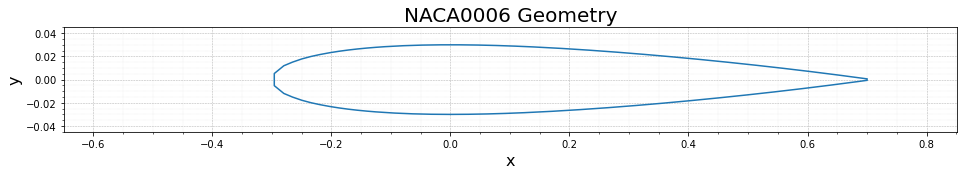

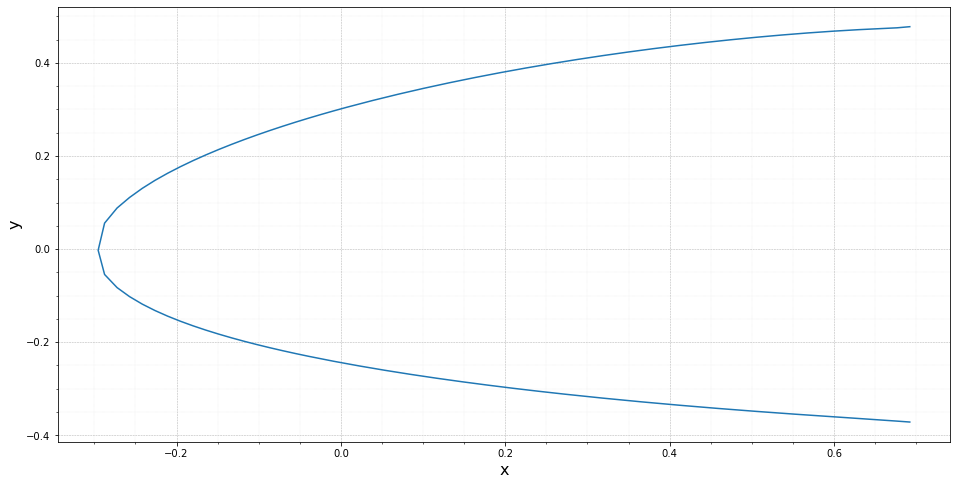

In [153]:
N = 129
U0 = 1
AOA = 15
airfoilName = "NACA0006"
airfoilDat = ReadAirfoilDat( airfoilName )
X, Y = ProcessDat( airfoilDat )
PlotAirfoil( N, airfoilName )

A, B, sigma, x, y, xc, yc = DirichletConstantStrengthSourceDoubletMethod( X, Y, N, U0, AOA )
print( A )
print( B )
print(sigma)
b = np.matmul( B, sigma )

fig, ax = plt.subplots(figsize=(16, 8))
plt.grid(b=True, which='major', linestyle='--', linewidth=.5)
plt.grid(b=True, which='minor', linestyle='--', linewidth=.1)
plt.minorticks_on()
plt.xlabel(xlabel='x', fontsize=16)
plt.ylabel(ylabel='y', fontsize=16)
nu = np.linalg.solve( A, -b )
print( -nu[-1]*2 )
nu = nu[:-1]
plt.plot( xc, nu )





## 9. Boundary Integral Method using Trapezoidal Rule

The velocity potential inside the airfoil is constant, so we botain:
<center> $ \phi(x, z) = \int_{S_B} [ \frac{\partial \phi}{\partial n}G - \phi \frac{\partial G}{\partial n} ]dS - \Delta \phi \int_{S_W} \frac{ \partial \phi }{\partial n} dS + \phi_{\infty} = const $ </center>

<center> $ \Rightarrow -\int_{S_B} \phi \frac{\partial G}{\partial n} dS - \Delta \phi \int_{S_W} \frac{ \partial \phi }{\partial n} dS + \phi_{\infty} = const $ </center>

<center> $ \Rightarrow \int_{S_B} \phi \frac{\partial G}{\partial n} dS + \Delta \phi \int_{S_W} \frac{ \partial \phi }{\partial n} dS = \phi_{\infty} $ </center>

In [ ]:
def computeGreenNormal2D( x, y, xj, yj , normalx, normaly, curvature ):
    if sqrt( (x-xj)**2 + (y-yj)**2 ) < 1e-6:
        return curvature/2
    rj2 = (x - xj)**2 + (y - yj)**2
    dGdr = ( 1 / 2 / pi ) / rj2 
    gradrn = normalx * (x - xj) + normaly * (y - yj)
    return -dGdr * gradrn


def DirichletTrapezoidalRule( X, Y, N, U0, AOA ):
    
    ## check if the geometry has sharp trailing edge
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    tx, ty = computeTangent( N+1, tck )
    x, y = computeNodeLocations( N+1, tck )
    theta = np.arctan2( y[:], x[:] )
    ds_dt = computeNormParameterizationDerivative( N+1, tck )
    nx, ny = computeNormal( N+1, tck )
    binormal = computeBinormal( N+1, tck )
    curvature = computeCurvature( N+1, tck )
    dt = 1/ N
    ds = ds_dt[0]*dt
    
    ## create  collocation points
    
    
    ## correct normal direction
    nx = binormal * nx
    ny = binormal * ny
    
    ## generate system of equations
    A = np.eye( N + 1 )/2
    b = np.zeros( N + 1 )
    
    
    
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( dy, dx )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## displace collocation point inward by 0.05 of the panel length
    xc = xc - 0.05*panelLength*nxc; yc = yc - 0.05*panelLength*nyc;
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+1)x(N+1) sys of eqns related to the source elements
    B = np.zeros( (N+1, N+1) )
    sigma = np.zeros( N+1 )

def DirichletConstantStrengthSourceDoubletMethod( X, Y, N, U0, AOA ):
    
    # generate geometry
    # for N panels we need N+1 points
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tck = createSplines( X, Y )
    x, y = computeNodeLocations( N+1, tck )
    dx = np.diff(x)
    dy = np.diff(y)
    panelLength = np.sqrt( dx**2 + dy**2 )

    ## generate collocation point data
    xc = ( x[1:] + x[:-1] )/2; yc = ( y[1:] + y[:-1] )/2;
    panelAlpha = np.arctan2( dy, dx )
    nxc = np.sin( panelAlpha )
    nyc = -np.cos( panelAlpha )
    
    ## displace collocation point inward by 0.05 of the panel length
    xc = xc - 0.05*panelLength*nxc; yc = yc - 0.05*panelLength*nyc;
    
    ## generate wake geometry
    tckw = createWakeGeometry( X, Y, AOA )
    xw, yw = computeNodeLocations( N+1, tckw )
    
    # generate a (N+1)x(N+1) sys of eqns related to the source elements
    B = np.zeros( (N+1, N+1) )
    sigma = np.zeros( N+1 )
    
    for i in range( N ):
        sigma[i] = -U0 * ( np.cos( AOA * pi / 180 )*nxc[i] + np.sin( AOA * pi / 180 )*nyc[i] )
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICS( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            B[i, j] = phi
    
    
    # generate a (N+2)x(N+2) system of equations related to the doublet elements
    # where the last row is to apply the kutta-condition
    A = np.zeros( (N + 1, N+1) )
    b = np.zeros( N + 1 )
    
    ## row of matrix
    for i in range( N ):
        for j in range( N ):
            ## first panel point & second panel point
            phi = PHICD( xc[i], yc[i], x[j], y[j], x[j+1], y[j+1] )
            A[i, j] = phi
            
            
    ## include wake effect
    for i in range( N ):
        for j in range( N ):
            phi = PHICD( xc[i], yc[i], xw[j], yw[j], xw[j+1], yw[j+1] )
            A[i, -1] = A[i, -1] + phi
    
    ## include Kutta Condition
    A[N, 0] = 1; A[N, -2] = -1; A[N, -1] = 1     

    return A, B, sigma, x, y, xc, yc


print("PHICS")
ds = 1e-8
phi0 = PHICS(0, 0, 1, 0, -1, 0)
phi1 = PHICS(0, 0+ds, 1, 0, -1, 0)
phi2 = PHICS(0, 0-ds, 1, 0, -1, 0)
print("Obtaining the num limit to 0+ of u")
print( (phi1-phi0)/ds )
print( .5 )
print("Obtaining the num limit to 0+ of u")
print( (phi0-phi2)/ds )
print( -.5 )
print("\n")

print("PHICD")
print("Taking the num limit to 0+ of phi")
phi = PHICD(0, 0+1e-12, 1, 0, -1, 0)
print( phi )  
print( 1/2 )
print("")
print("Taking the num limit to 0- of phi")
phi = PHICD(0, 0-1e-12, 1, 0, -1, 0)
print( phi )  
print( -1/2 )
print("")






